# Preprocessing and Analysis of Stroke Subjects in the Gait Rehabilitation Project

- Focuses on understanding gait patterns and biomechanics in healthy individuals.
- Provides baseline data for comparison with patients undergoing rehabilitation.
- Aims to identify key metrics for evaluating gait performance and recovery progress.
- Creates a new dataset that simplifies the process of data usage, from EDA, ETL and machine learning training 

In [1]:

# Import libraries
import os, sys, math, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import merge_data, aggregate_features, clean_extra_files
from feature_extraction import time_domain_features, frequency_domain_features, gait_features, cross_limb_features

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Static variables and paths
base_dir = 'Data/Stroke'

---

# Preprocessing - Feature Extraction

### Data preprocessing

- Combines data from the left and right shank into a single dataframe.
- Facilitates ease of use by consolidating information for both sides.
- Ensures consistency in data structure for analysis and modeling.
- Allows for streamlined processing and comparison of gait metrics across both sides.

### Feature Extraction
- Extract relevant **Time Domain Features** like: Mean, Standard Deviation, Maximum, Minimum, Root Mean Square, Median Absolute Deviation, Range, Interquartile Range, Skewness & Kurtosis, Zero-crossing rate, Peak count / amplitude.

- Extract relevant **Frequency Domain Features** in a 2sec windows like: Dominant frequency, Spectral entropy, Gait band energy.

- Extract relevant **Gait Features**: Stride times, Stance/swing times, Asymmetry index, Symmetry ratio.

- Extract relevant **Cross Limb Features**: Left and right stride durations, stride duration difference, stride duration symmetry ratio.


In [2]:
# Loop over each patient folder
for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)
    
    if not os.path.isdir(patient_path):
        continue 

    print(f"\nProcessing {patient_folder}...")

    # 1. Merge gyroscope data for the patient
    left_path = os.path.join(patient_path, 'LeftShank-Gyroscope.csv')
    right_path = os.path.join(patient_path, 'RightShank-Gyroscope.csv')
    merge_data(patient_path + '/', left_path, right_path, 'gyroscope')

    # 2. Run all feature extraction functions 
    time_domain_features(patient_path + '/', 'gyroscope')
    frequency_domain_features(patient_path + '/', 'gyroscope')
    gait_features(patient_path + '/', 'gyroscope')
    cross_limb_features(patient_path + '/', 'gyroscope')


Processing Patient_1...

Processing Patient_6...

Processing Patient_7...

Processing Patient_5...

Processing Patient_2...

Processing Patient_3...

Processing Patient_4...


---

# Explanatory Data Analysis

## Time Domain Features

|Plot Type| What to Plot                        | Why Useful               |
|---------|-------------------------------------|--------------------------|
|Bar Plot | mean, std, rms, mad (left vs right)	|Quick symmetry overview   |

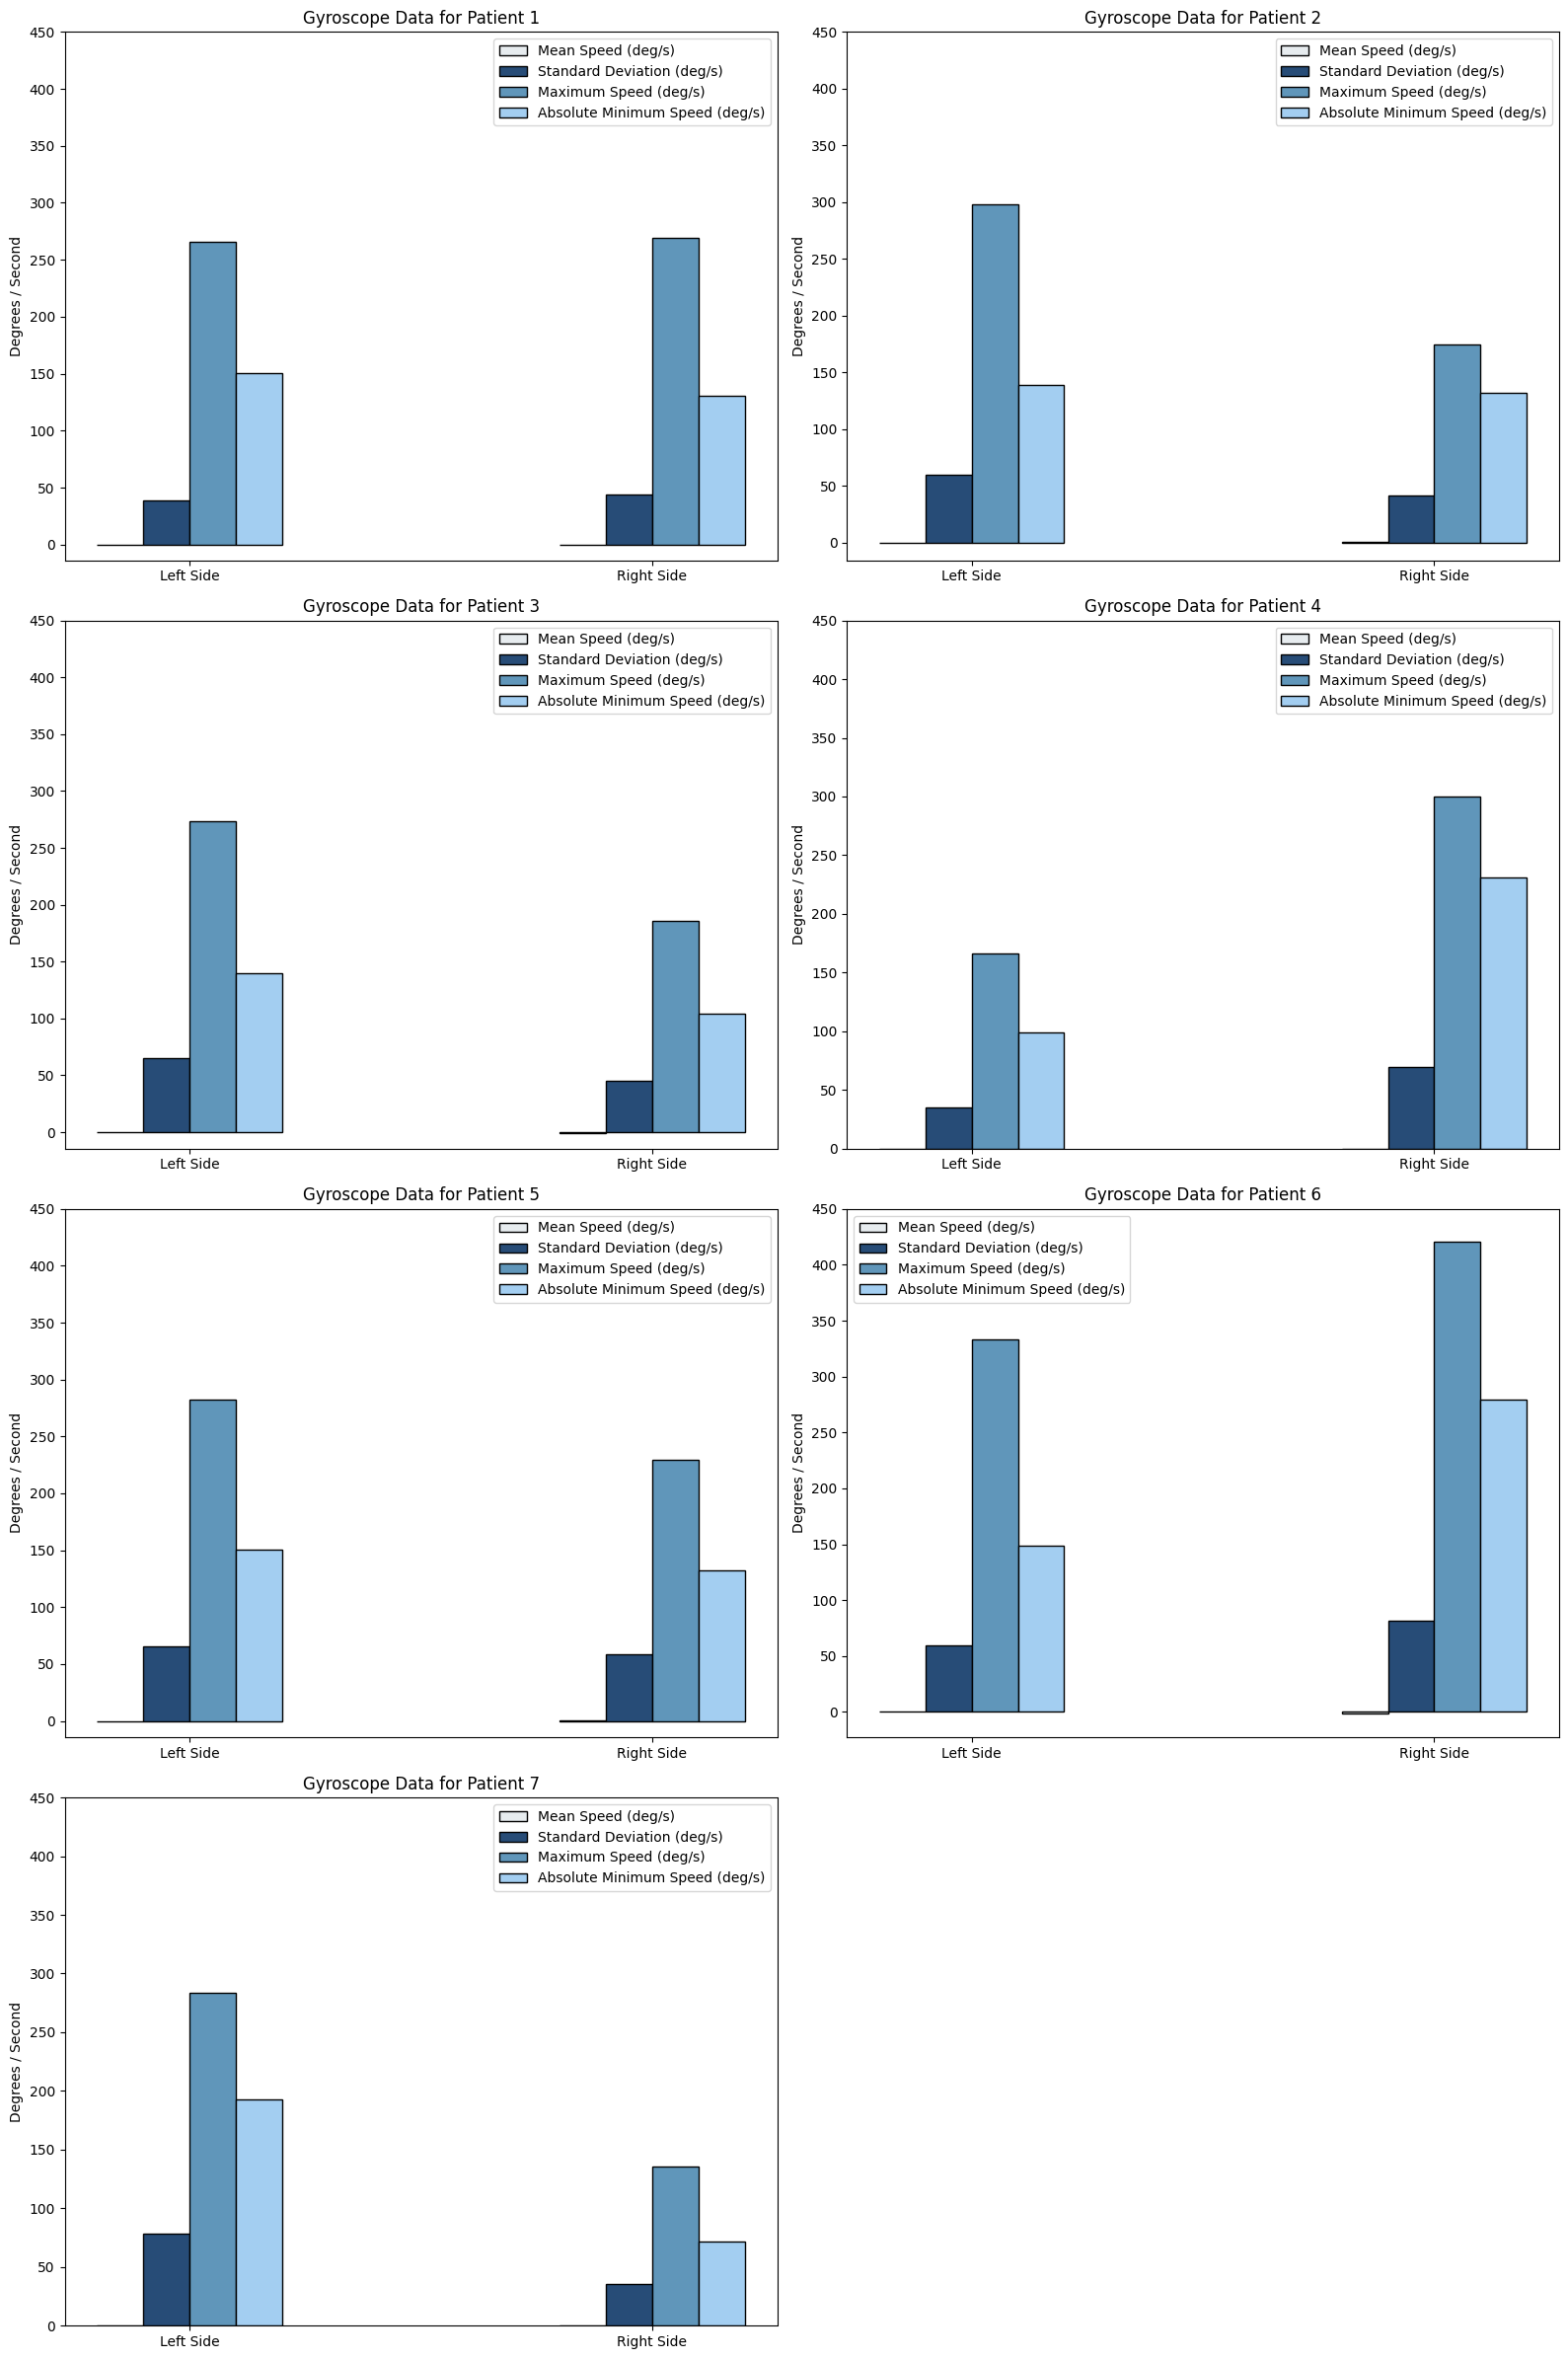

Values seen here are Left, Right Side respectively
Overall Healthy Mean: [ 0.01929627 -0.2083636 ]
Overall Healthy Std: [57.58854902 53.68404551]
Overall Healthy Max: [271.77728571 245.08714286]
Overall Healthy Min: [145.79271429 154.52957143]


In [3]:
# Load the Time Domain Features Metrics CSV files
time_domain_features_paths = [os.path.join(base_dir, patient_folder, 'time_domain_metrics_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
time_domain_features_paths = [path for path in time_domain_features_paths if path.__contains__('.DS_Store') == False]


# Overall Average Healthy patient data
healthy_mean = []
healthy_std = []
healthy_max = []
healthy_min = []

# Calculate number of rows needed (2 plots per row)
n_patients = len(time_domain_features_paths)
n_cols = 2
n_rows = math.ceil(n_patients / n_cols)

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
axes = axes.flatten()  # Flatten in case it's 2D array

for idx, path in enumerate(time_domain_features_paths):
    data = pd.read_csv(path)
    
    left_mean = data['left-z-axis-(deg/s)-mean']
    left_std = data['left-z-axis-(deg/s)-std']
    left_max = data['left-z-axis-(deg/s)-max']
    left_min = abs(data['left-z-axis-(deg/s)-min'])
    
    right_mean = data['right-z-axis-(deg/s)-mean']
    right_std = data['right-z-axis-(deg/s)-std']
    right_max = data['right-z-axis-(deg/s)-max']
    right_min = abs(data['right-z-axis-(deg/s)-min'])

    mean = [left_mean.iloc[0], right_mean.iloc[0]]
    std = [left_std.iloc[0], right_std.iloc[0]]
    max_ = [left_max.iloc[0], right_max.iloc[0]]
    min_ = [left_min.iloc[0], right_min.iloc[0]]
    
    # Append to overall healthy data
    healthy_mean.append(mean)
    healthy_std.append(std)
    healthy_max.append(max_)
    healthy_min.append(min_)

    barWidth = 0.1
    r1 = np.arange(len(mean))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    
    ax = axes[idx]

    ax.bar(r1, mean, width=barWidth, color='#e7ecef', edgecolor='black', capsize=7, label='Mean Speed (deg/s)')
    ax.bar(r2, std, width=barWidth, color='#274c77', edgecolor='black', capsize=7, label='Standard Deviation (deg/s)')
    ax.bar(r3, max_, width=barWidth, color='#6096ba', edgecolor='black', capsize=7, label='Maximum Speed (deg/s)')
    ax.bar(r4, min_, width=barWidth, color='#a3cef1', edgecolor='black', capsize=7, label='Absolute Minimum Speed (deg/s)')

    ax.set_xticks([r + 1.5*barWidth for r in range(len(mean))])
    ax.set_xticklabels(['Left Side', 'Right Side'])
    ax.set_yticks(np.arange(0, 500, 50))
    ax.set_ylabel('Degrees / Second')
    ax.set_title(f'Gyroscope Data for Patient {idx + 1}')
    ax.legend()

# Hide the empty subplot if the number is odd
if n_patients % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("Values seen here are Left, Right Side respectively")
print("Overall Healthy Mean:", np.mean(healthy_mean, axis=0))
print("Overall Healthy Std:", np.mean(healthy_std, axis=0))
print("Overall Healthy Max:", np.mean(healthy_max, axis=0))
print("Overall Healthy Min:", np.mean(healthy_min, axis=0))

## Frequency Domain Features

| Plot Type | What to Plot                       | Why Useful                                      |
|-----------|------------------------------------|-------------------------------------------------|
| Bar Plot  | Dominant frequency (left vs right) | See walking cadence/speed symmetry              |
| Heatmap   | Spectral entropy across patients   | Complexity of gait signal                       |
| Line Plot | FFT power spectral density curves  | Compare energy distribution of gait frequencies |

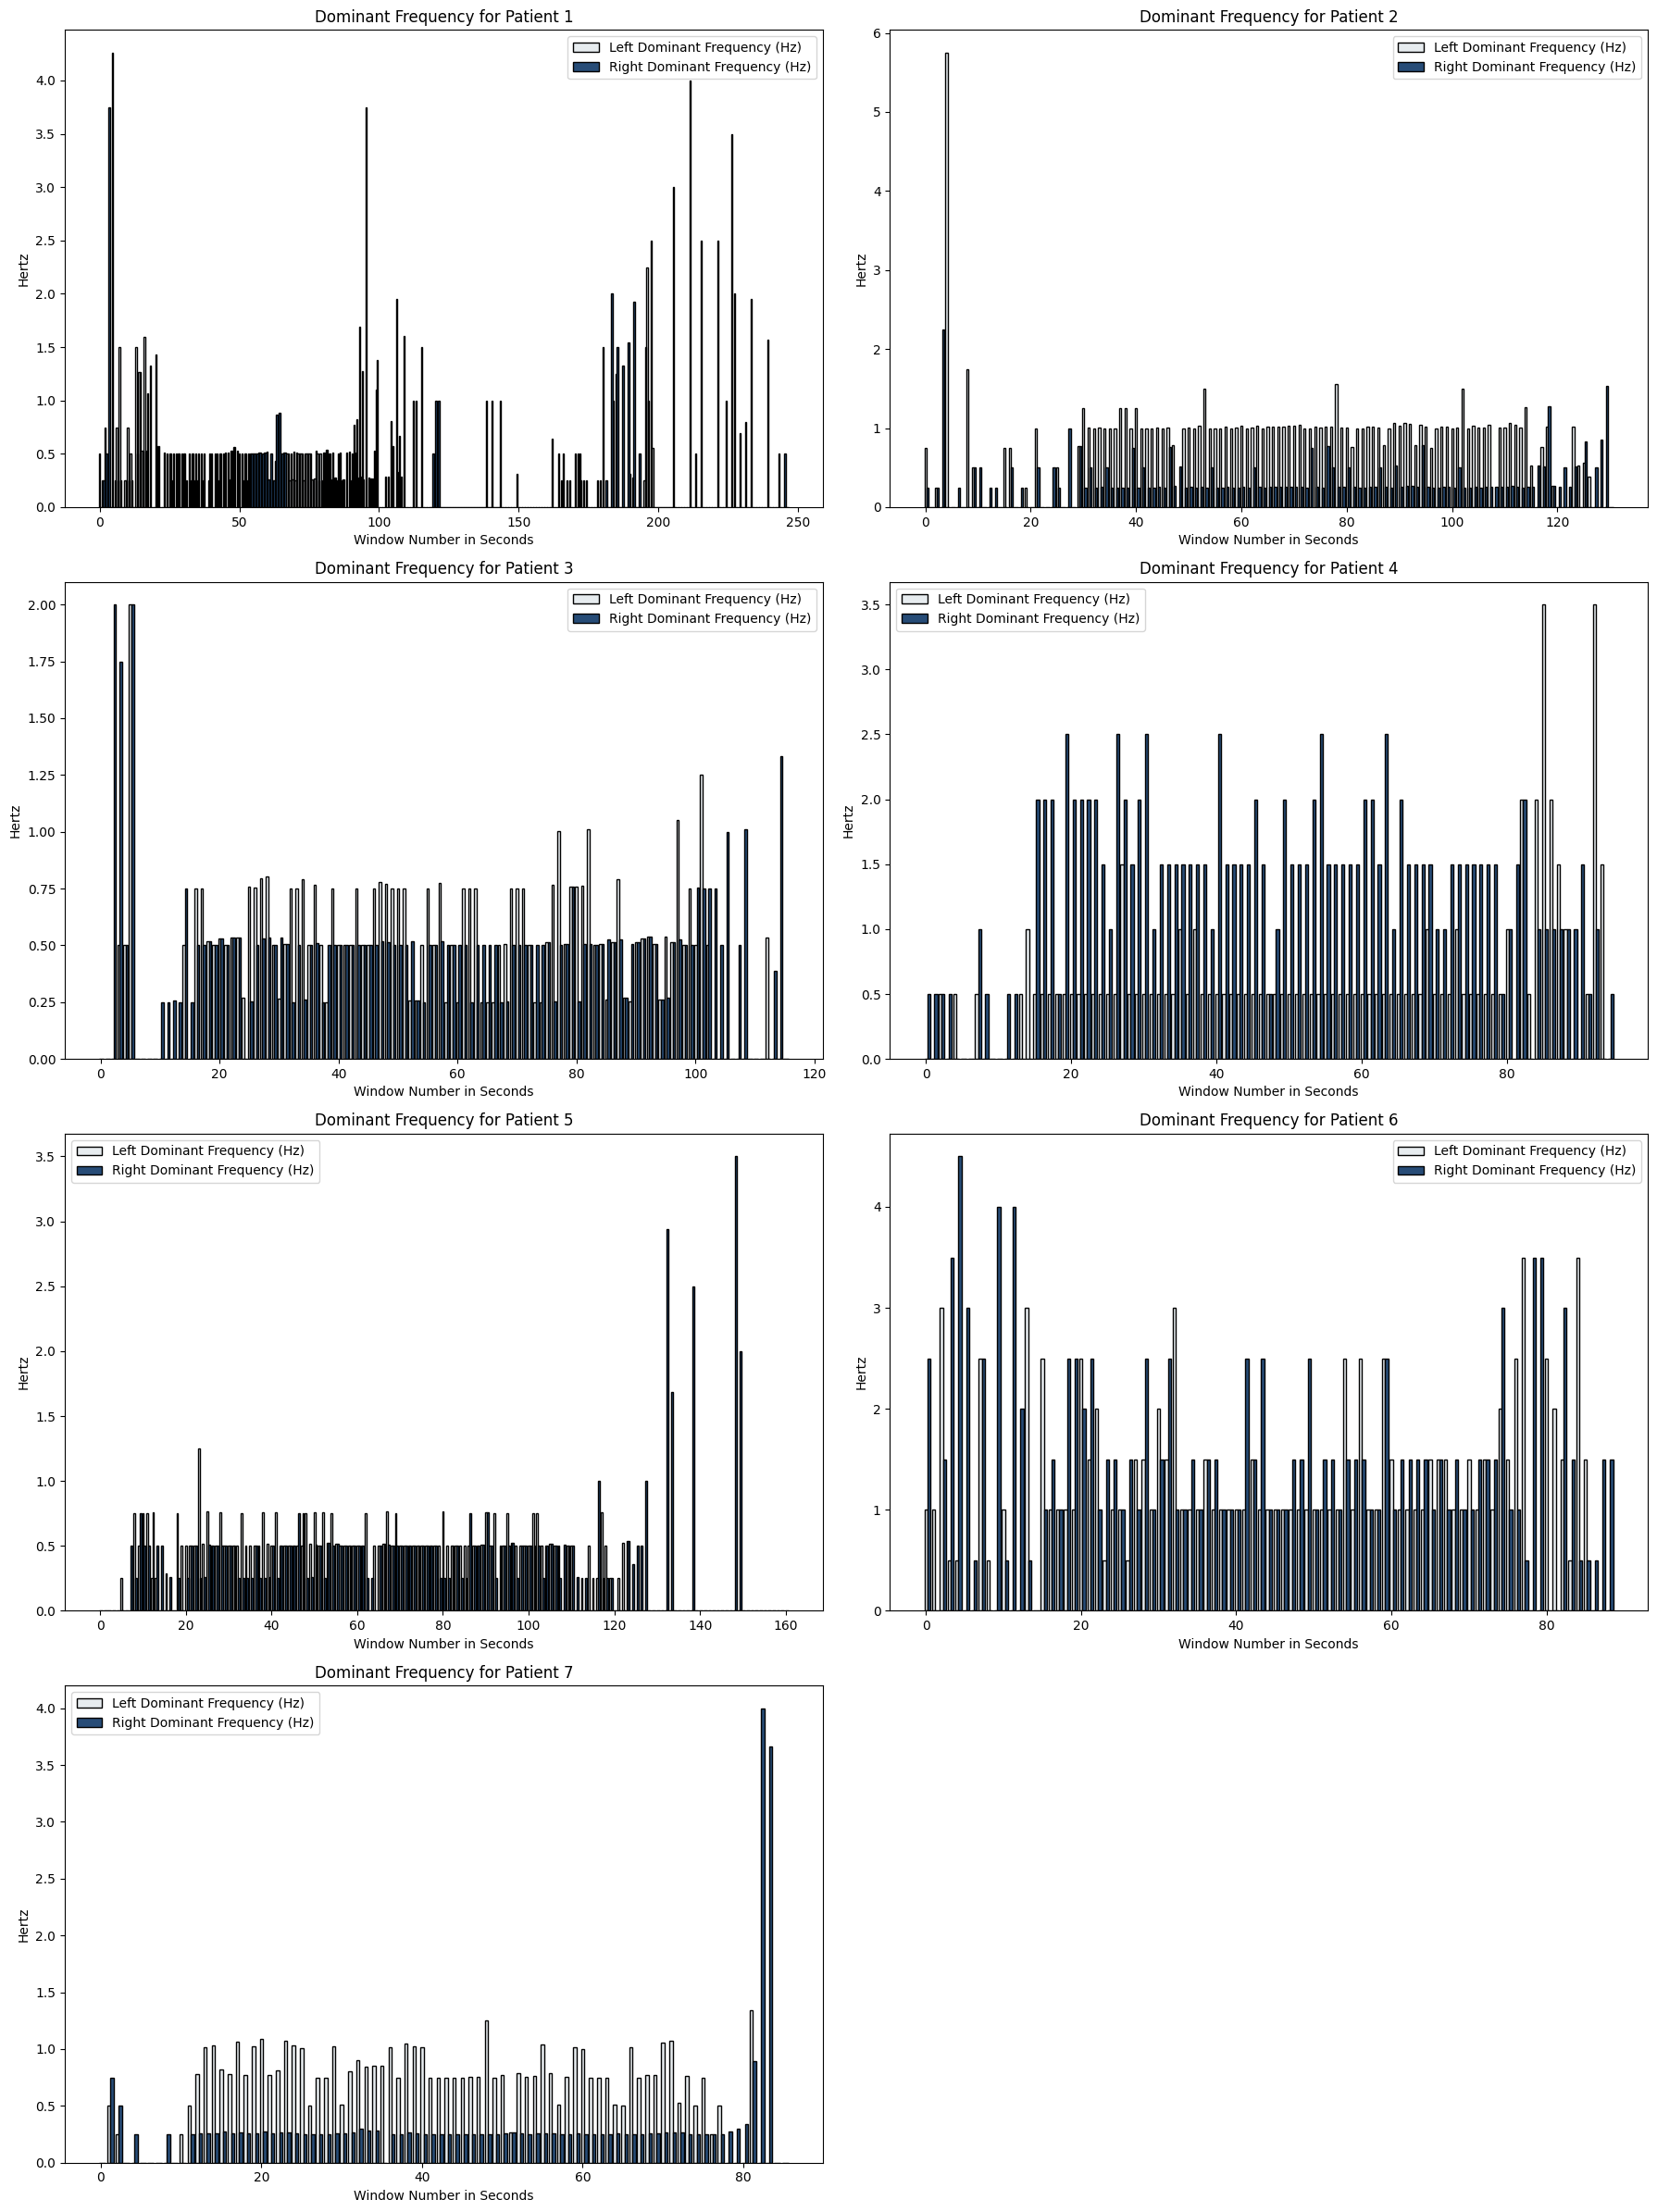

In [4]:
# Load the Frequency Domain Features Metrics CSV files
frequency_domain_features_paths = [os.path.join(base_dir, patient_folder, 'windowed_frequency_features_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
frequency_domain_features_paths = [path for path in frequency_domain_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(frequency_domain_features_paths)
n_cols = 2
n_rows = math.ceil(n_patients / n_cols)

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

for idx, path in enumerate(frequency_domain_features_paths):
    data = pd.read_csv(path)
    
    left_dominant_freq  = data.loc[data['side'] == 'left']['dominant_freq']
    right_dominant_freq = data.loc[data['side'] == 'right']['dominant_freq']

    barWidth = 0.4
    r1 = np.arange(len(left_dominant_freq))
    r2 = [x + barWidth for x in r1]
    
    ax = axes[idx]

    ax.bar(r1, left_dominant_freq,  width=barWidth, color='#e7ecef', edgecolor='black', capsize=7, label='Left Dominant Frequency (Hz)')
    ax.bar(r2, right_dominant_freq, width=barWidth, color='#274c77', edgecolor='black', capsize=7, label='Right Dominant Frequency (Hz)')
    ax.set_xlabel('Window Number in Seconds')
    ax.set_ylabel('Hertz')
    ax.set_title(f'Dominant Frequency for Patient {idx + 1}')
    ax.legend()

# Hide the empty subplot if the number is odd
if n_patients % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In this case for the **Patients 2,4 and 5** we have relatively stable bar heights over time which means good gait regularity. In some cases like the **Patients 1 and 3**, left and right frequencies separate slightly in certain windows, which could hint very mild asymmetry, but still within normal for healthy people. Some spikes to very high frequencies like 2.5 Hz in **Patient 6**, might be sensor noise or accidental sharp movement.

<br><br/>
| Gait Type           | Dominant Frequency Range|
|---------------------|-------------------------|
| Healthy walking     | ~0.8 Hz to ~1.6 Hz      |
| Very slow walking   | ~0.5 Hz                 |
| Running             | ~2.0–3.0 Hz             |
| Tremors (pathology) | > 4 Hz                  |

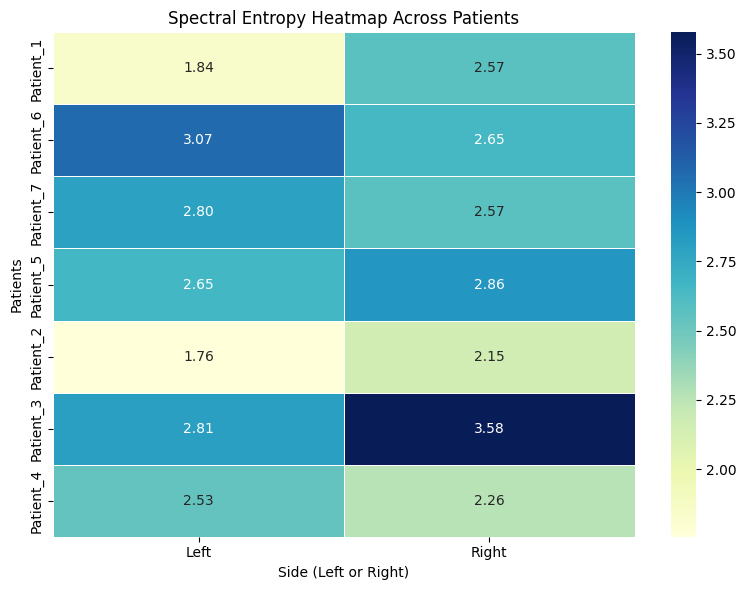

In [5]:
# Load the Frequency Domain Features Metrics CSV files
frequency_domain_features_paths = [os.path.join(base_dir, patient_folder, 'windowed_frequency_features_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
frequency_domain_features_paths = [path for path in frequency_domain_features_paths if path.__contains__('.DS_Store') == False]

patient_spectral_entropy = []

for path in enumerate(frequency_domain_features_paths):
    data = pd.read_csv(path[1])
    left_spectral_entropy  = data.loc[data['side'] == 'left']['spectral_entropy']
    right_spectral_entropy = data.loc[data['side'] == 'right']['spectral_entropy']
    patient_spectral_entropy.append([path[1].split('/')[2], left_spectral_entropy.mean(), right_spectral_entropy.mean()])



# Convert collected data into a DataFrame
entropy_df = pd.DataFrame(patient_spectral_entropy, columns=['Patient', 'Left', 'Right'])
entropy_df.set_index('Patient', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(entropy_df, annot=True, cmap="YlGnBu", linewidths=0.5, fmt=".2f")
plt.title('Spectral Entropy Heatmap Across Patients')
plt.ylabel('Patients')
plt.xlabel('Side (Left or Right)')
plt.tight_layout()


# Show the figure
plt.show()

| Patient   | Left Entropy | Right Entropy | Difference | Notes              |
|-----------|--------------|---------------|------------|--------------------|
| Patient_1 | 1.93 | 2.25 | ~0.32 | Small difference, still acceptable       |
| Patient_6 | 2.32 | 2.82 | 0.50 | Slightly higher difference (keep an eye)  |
| Patient_7 | 2.26 | 2.49 | ~0.23 | Good symmetry                            |
| Patient_5 | 2.46 | 2.64 | ~0.18 | Good symmetry                            |
| Patient_2 | 2.48 | 2.49 | ~0.01 | Excellent symmetry                       |
| Patient_3 | 2.13 | 2.59 | 0.46 | Noticeable asymmetry                      |
| Patient_4 | 2.76 | 2.65 | ~0.11 | Very good symmetry                       |

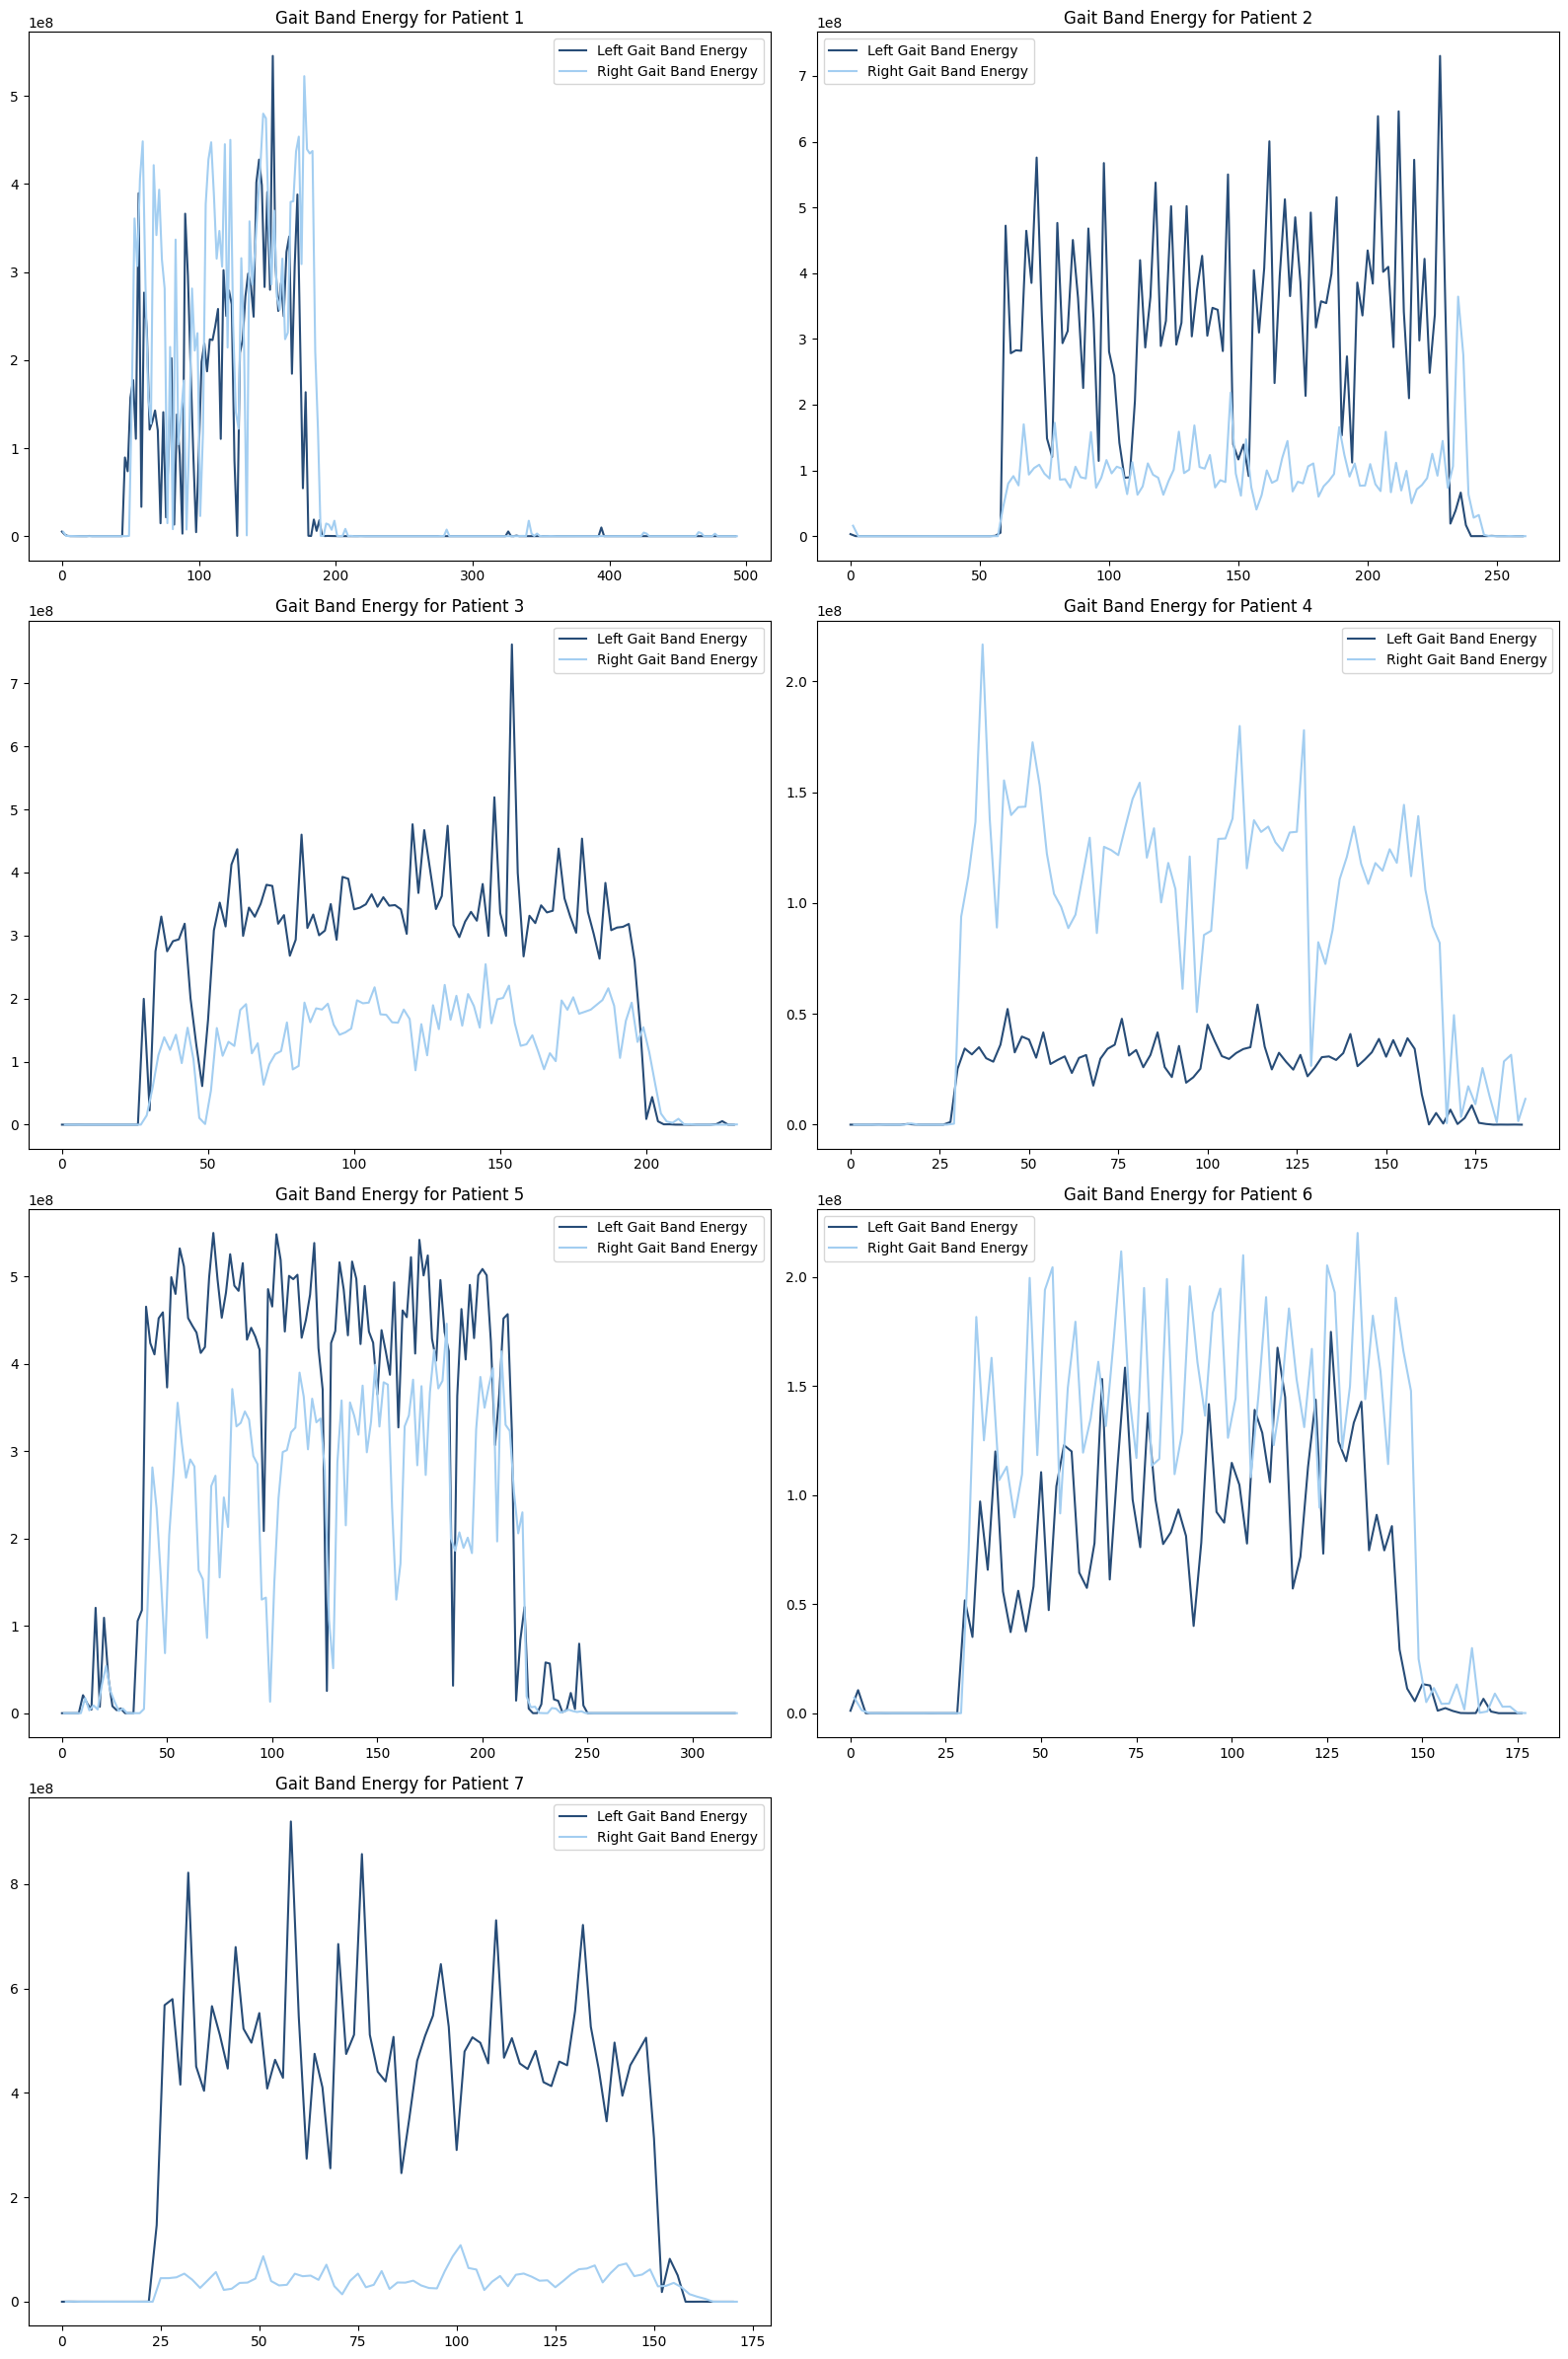

In [6]:
# Load the Frequency Domain Features Metrics CSV files
frequency_domain_features_paths = [os.path.join(base_dir, patient_folder, 'windowed_frequency_features_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
frequency_domain_features_paths = [path for path in frequency_domain_features_paths if path.__contains__('.DS_Store') == False]


# Calculate number of rows needed
n_patients = len(frequency_domain_features_paths)
n_cols = 2
n_rows = math.ceil(n_patients / n_cols)

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
axes = axes.flatten()

for idx, path in enumerate(frequency_domain_features_paths):
    data = pd.read_csv(path)
    left_gait_band_energy = data.loc[data['side'] == 'left']['gait_band_energy']
    right_gait_band_energy = data.loc[data['side'] == 'right']['gait_band_energy']
    
    ax = axes[idx] 

    ax.plot(left_gait_band_energy,  color='#274c77',  label='Left Gait Band Energy')
    ax.plot(right_gait_band_energy,  color='#a3cef1', label='Right Gait Band Energy')
    ax.legend()
    ax.set_title(f'Gait Band Energy for Patient {idx + 1}')
    

# Hide the empty subplot if the number is odd
if n_patients % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

| Property        | Expected Behavior           |
|-----------------|-----------------------------|
| Gait Energy     | Steady, high during walking |
| Left vs Right   | Nearly overlapping          |
| Pause detection | Energy drops to near zero   |

# Gait Features

| Plot Type        | What to Plot                                      | Why Useful                                     |
|------------------|---------------------------------------------------|------------------------------------------------|
| Histogram        | Distribution of stride times (left vs right)      | Check stride variability (irregular walking)   |
| Line Plot        | Stance and swing time trends over strides         | Check consistency of phases                    |
| Line Plot        | Symmetry of Left and Right Stride Time            | Check the symmetry between the stride times    |

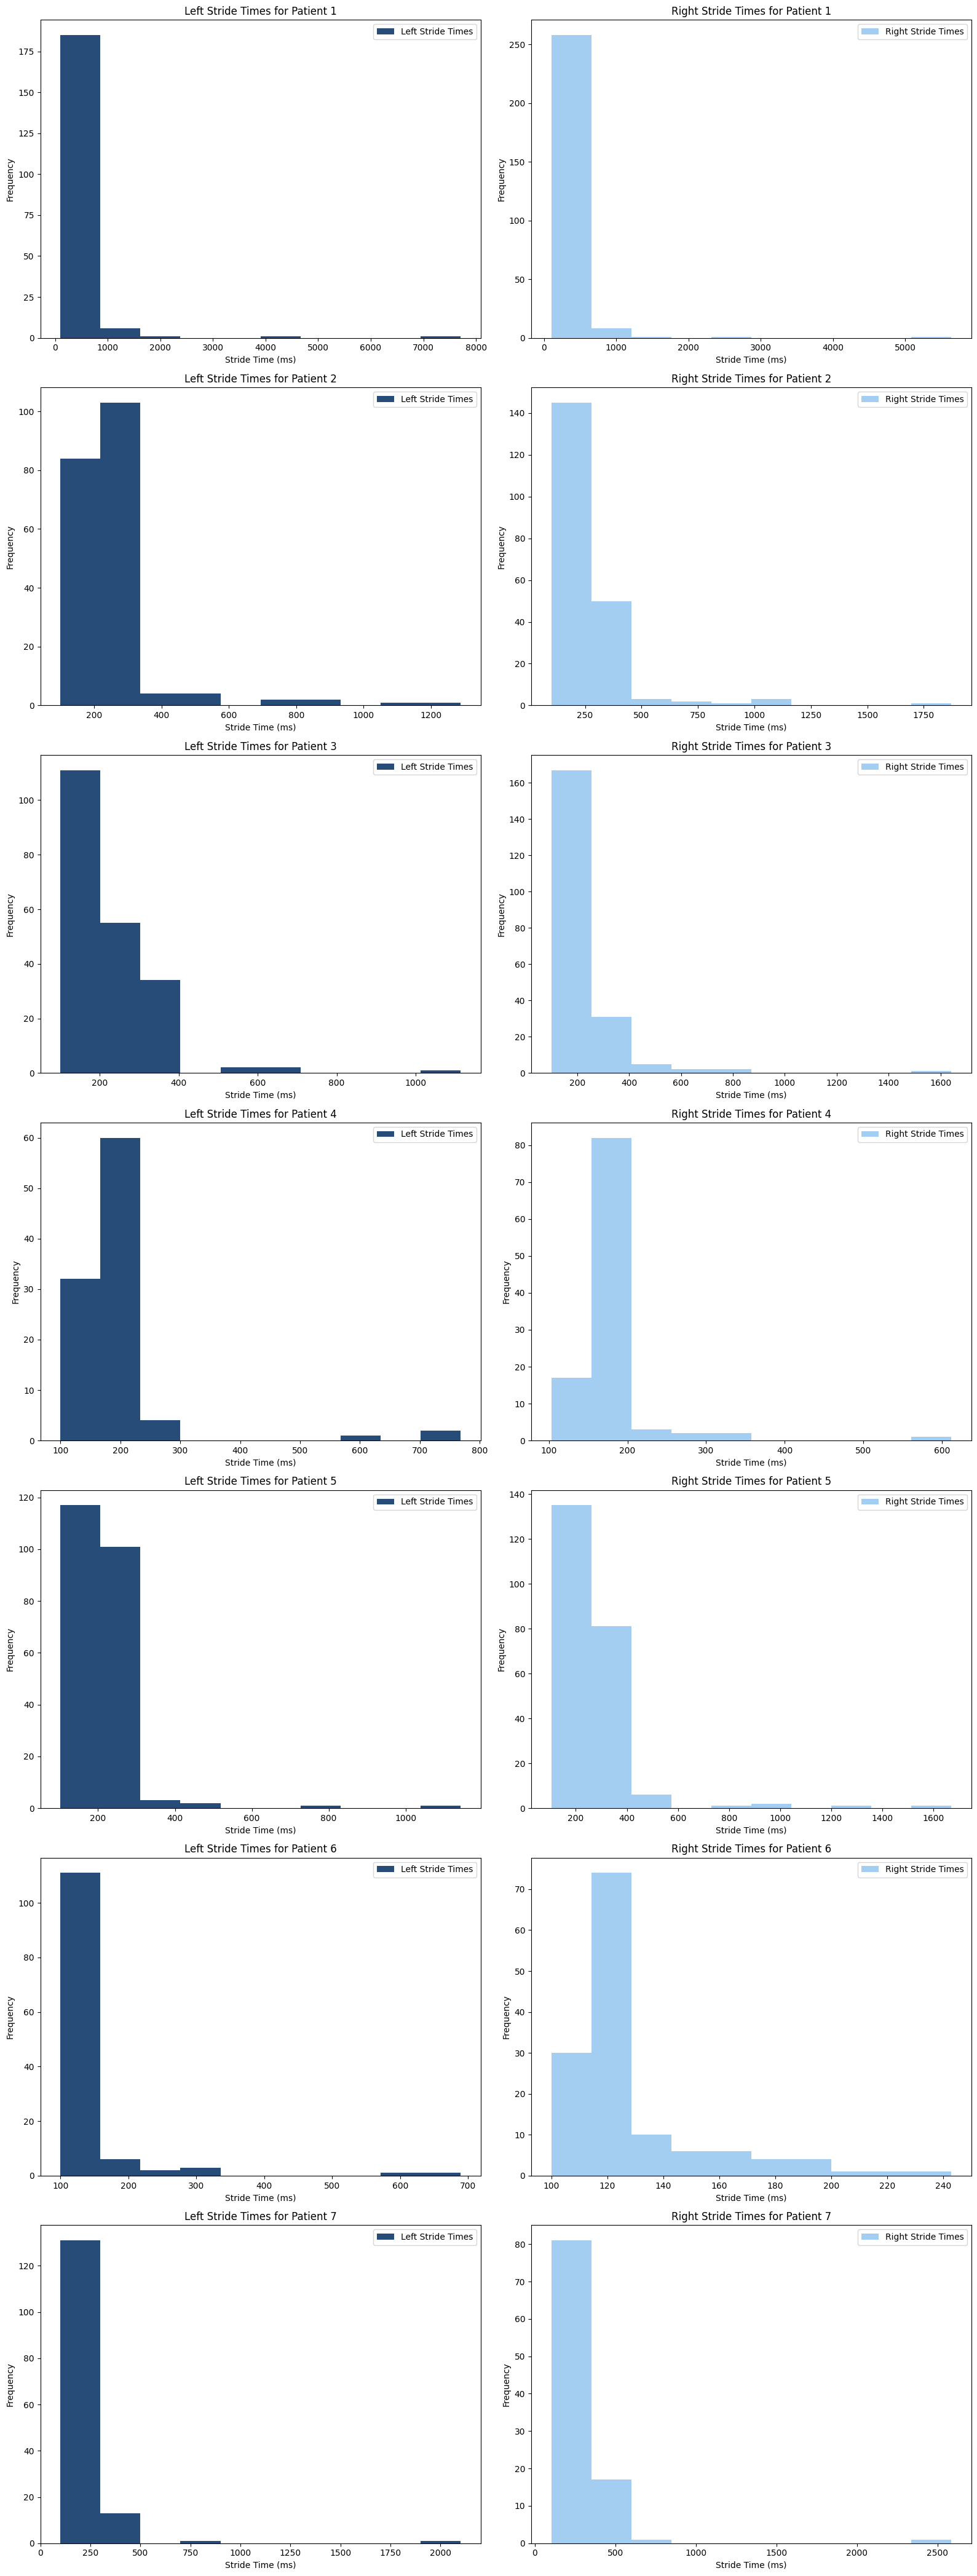

In [7]:
# Load the Gait Domain Features Metrics CSV files
gait_stride_features_paths = [os.path.join(base_dir, patient_folder, 'gait_features') for patient_folder in os.listdir(base_dir)]
gait_stride_features_paths = [path for path in gait_stride_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(gait_stride_features_paths)
n_cols = 2
n_rows = n_patients

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))

for idx, path in enumerate(gait_stride_features_paths):
    
    left_stride_time = pd.read_csv(os.path.join(path, 'left_stride_gyroscope.csv'))
    right_stride_time = pd.read_csv(os.path.join(path, 'right_stride_gyroscope.csv'))
    
    ax = axes[idx]

    ax[0].hist(left_stride_time,  color='#274c77', label='Left Stride Times')
    ax[0].set_title(f'Left Stride Times for Patient {idx + 1}')
    ax[0].set_xlabel('Stride Time (ms)')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    ax[1].hist(right_stride_time, color='#a3cef1', label='Right Stride Times')
    ax[1].set_title(f'Right Stride Times for Patient {idx + 1}')
    ax[1].set_xlabel('Stride Time (ms)')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    

plt.tight_layout()
plt.show()

As we can see the stride times between the right and left leg are pretty similar, showing stability in the movement between the stride times of the legs.

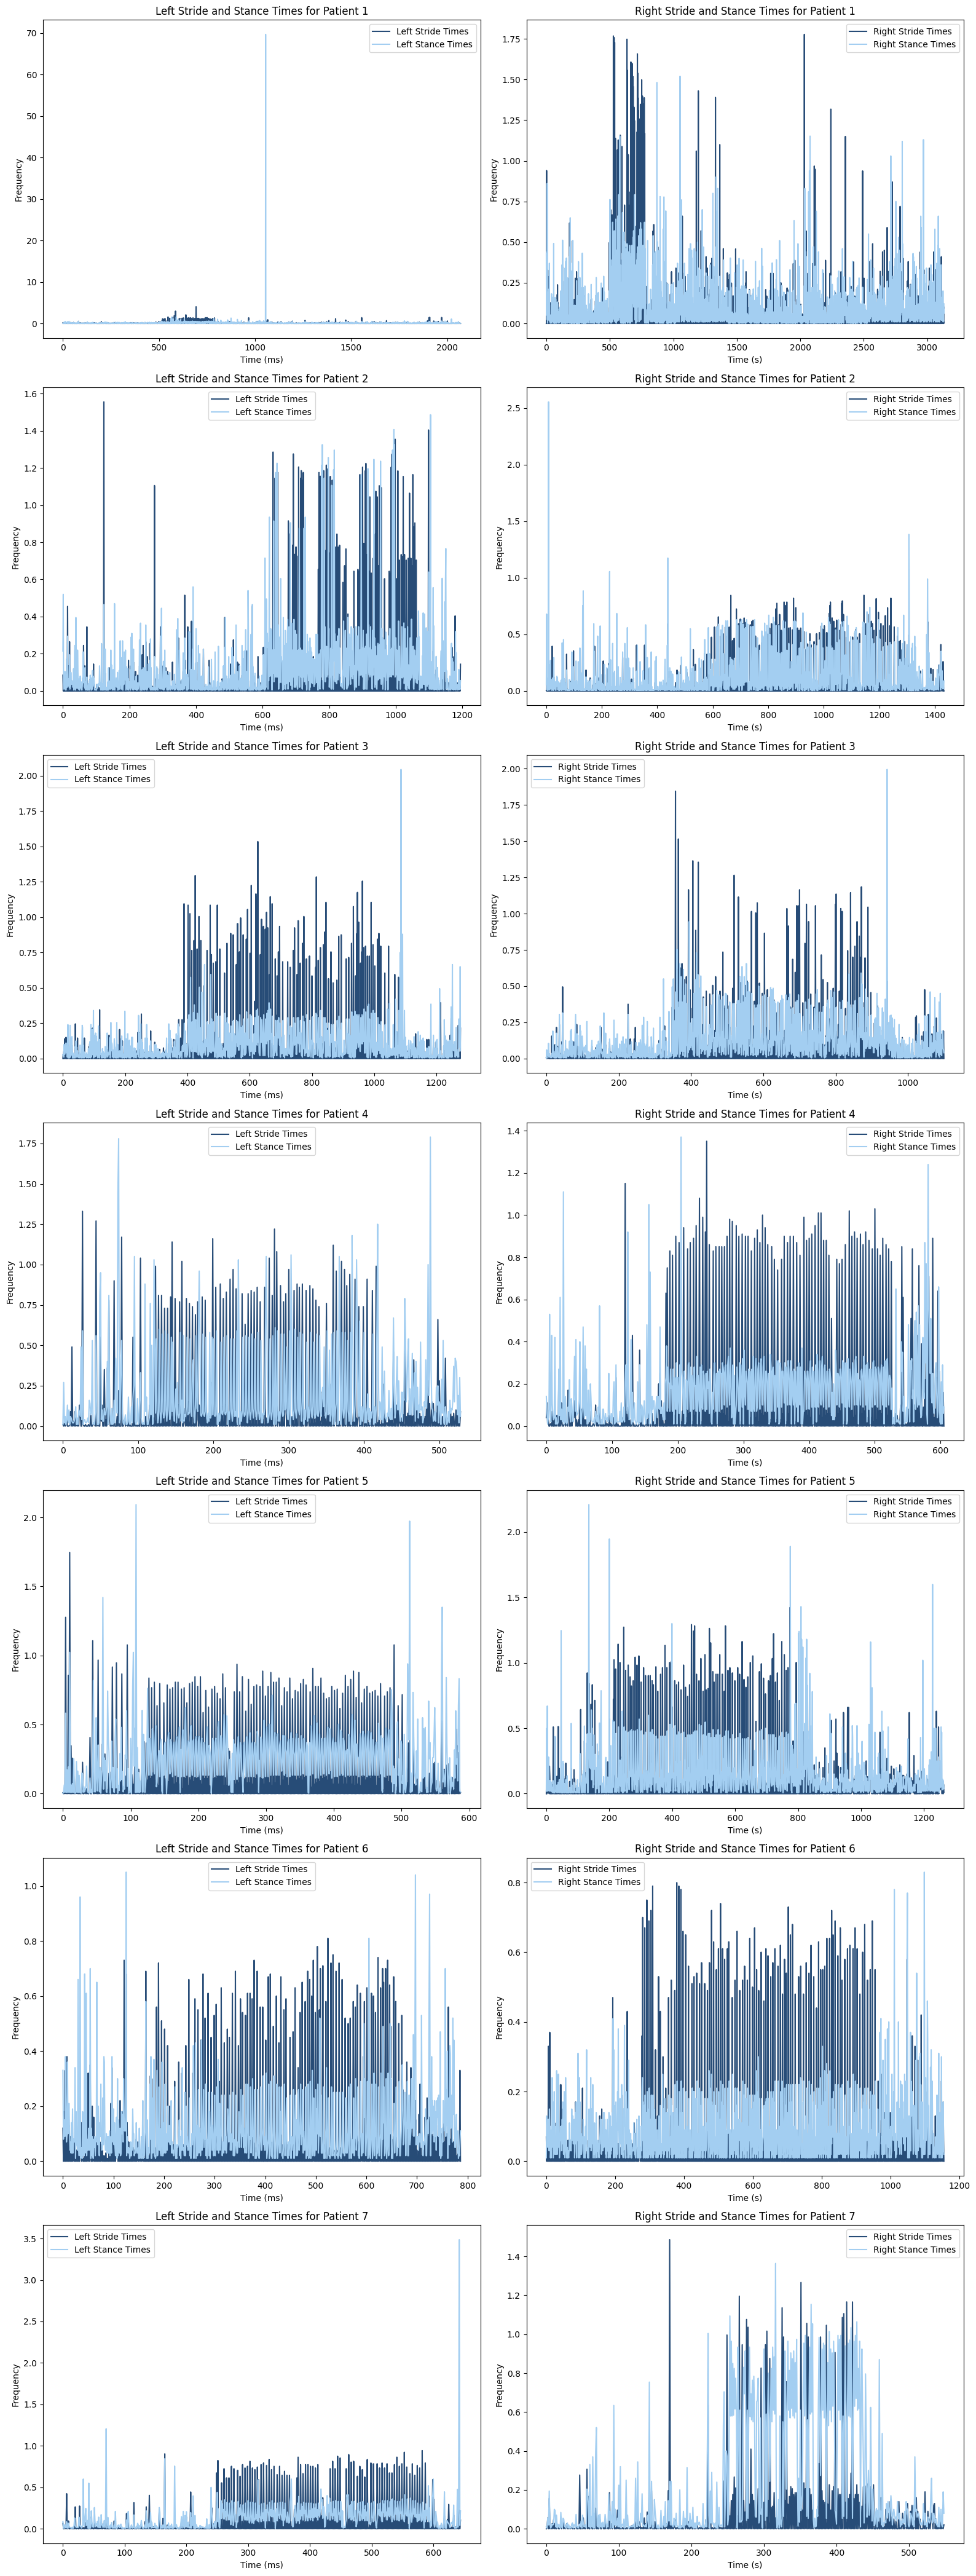

In [8]:
# Load the Gait Domain Features Metrics CSV files
gait_stride_features_paths = [os.path.join(base_dir, patient_folder, 'gait_features') for patient_folder in os.listdir(base_dir)]
gait_stride_features_paths = [path for path in gait_stride_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(gait_stride_features_paths)
n_cols = 2
n_rows = n_patients

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))

for idx, path in enumerate(gait_stride_features_paths):
    
    left_stance_swing_time  = pd.read_csv(os.path.join(path,  'left_stance_swing_gyroscope.csv'))
    right_stance_swing_time = pd.read_csv(os.path.join(path, 'right_stance_swing_gyroscope.csv'))
    
    ax = axes[idx]

    ax[0].plot(left_stance_swing_time['stance_time'], color='#274c77', label='Left Stride Times')
    ax[0].plot(left_stance_swing_time['swing_time'],  color='#a3cef1', label='Left Stance Times')
    ax[0].set_title(f'Left Stride and Stance Times for Patient {idx + 1}')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    ax[1].plot(right_stance_swing_time['stance_time'], color='#274c77', label='Right Stride Times')
    ax[1].plot(right_stance_swing_time['swing_time'],  color='#a3cef1', label='Right Stance Times')   
    ax[1].set_title(f'Right Stride and Stance Times for Patient {idx + 1}')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

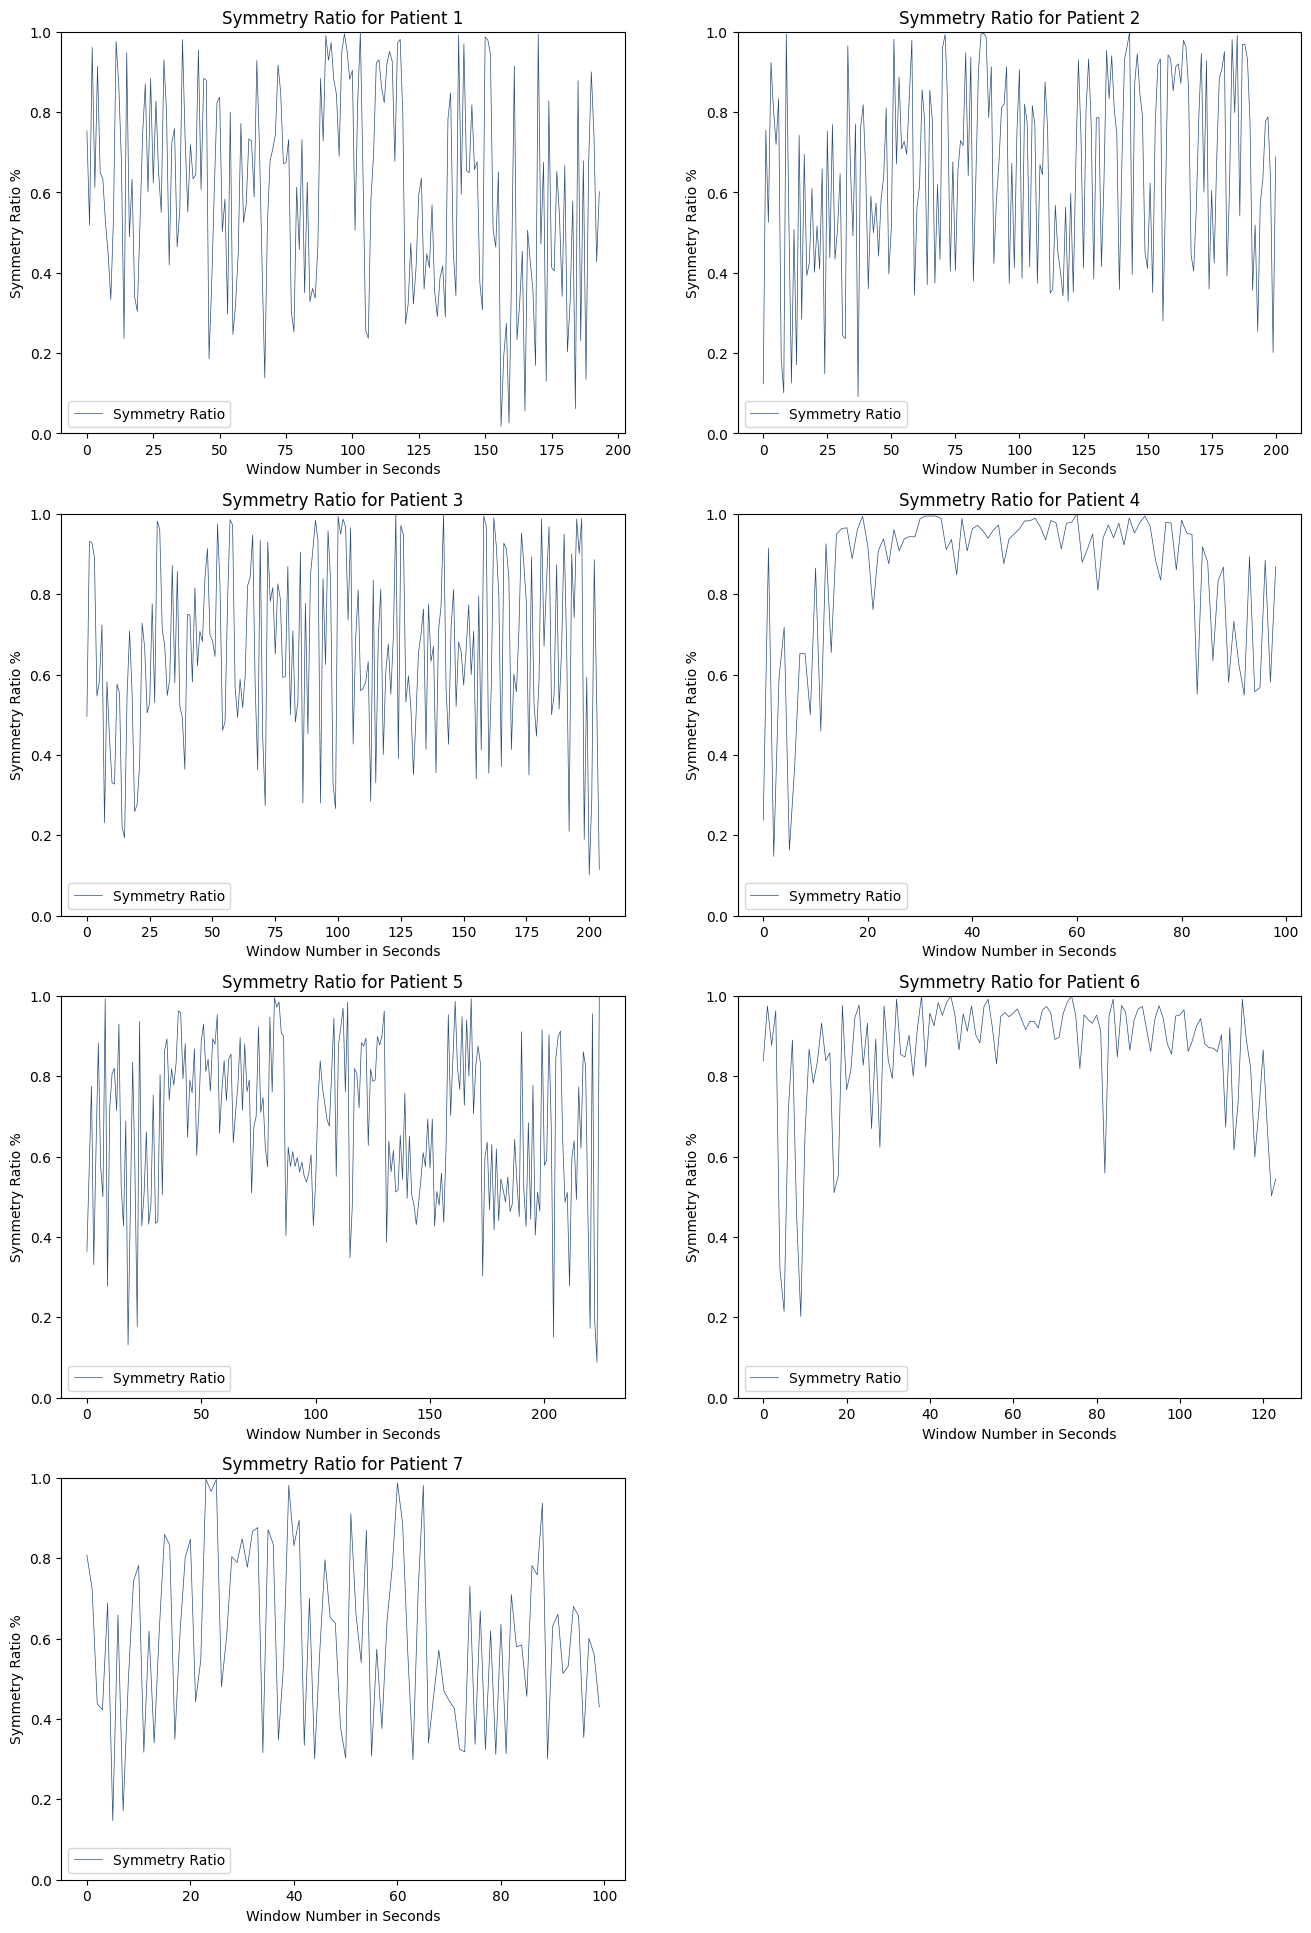

In [9]:
# Load the Gait Domain Features Metrics CSV files
gait_symmetry_features_paths = [os.path.join(base_dir, patient_folder, 'gait_features', 'summary_gait_metrics_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
gait_symmetry_features_paths = [path for path in gait_symmetry_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(gait_symmetry_features_paths)
n_cols = 2
n_rows = math.ceil(n_patients / n_cols)

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
axes = axes.flatten()

for idx, path in enumerate(gait_symmetry_features_paths):
    data = pd.read_csv(path)
    symmetry = data['symmetry_ratio']
    
    ax = axes[idx]

    ax.plot(symmetry, color='#274c77', linewidth=0.5, label='Symmetry Ratio')
    ax.legend()
    ax.set_title(f'Symmetry Ratio for Patient {idx + 1}')
    ax.set_xlabel('Window Number in Seconds')
    ax.set_ylabel('Symmetry Ratio %')
    ax.set_ylim(0, 1)
    

# Hide the empty subplot if the number is odd
if n_patients % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout

# Cross-Limb Features
| Plot Type    | What to Plot                                | Why Useful                                      |
|--------------|---------------------------------------------|-------------------------------------------------|
| Line Plot    | Left vs Right stride durations, peak values | Clusters reveal symmetry or asymmetry           |
| Heatmap      | Symmetry ratio per stride across patients   | Visualize balance across strides                |

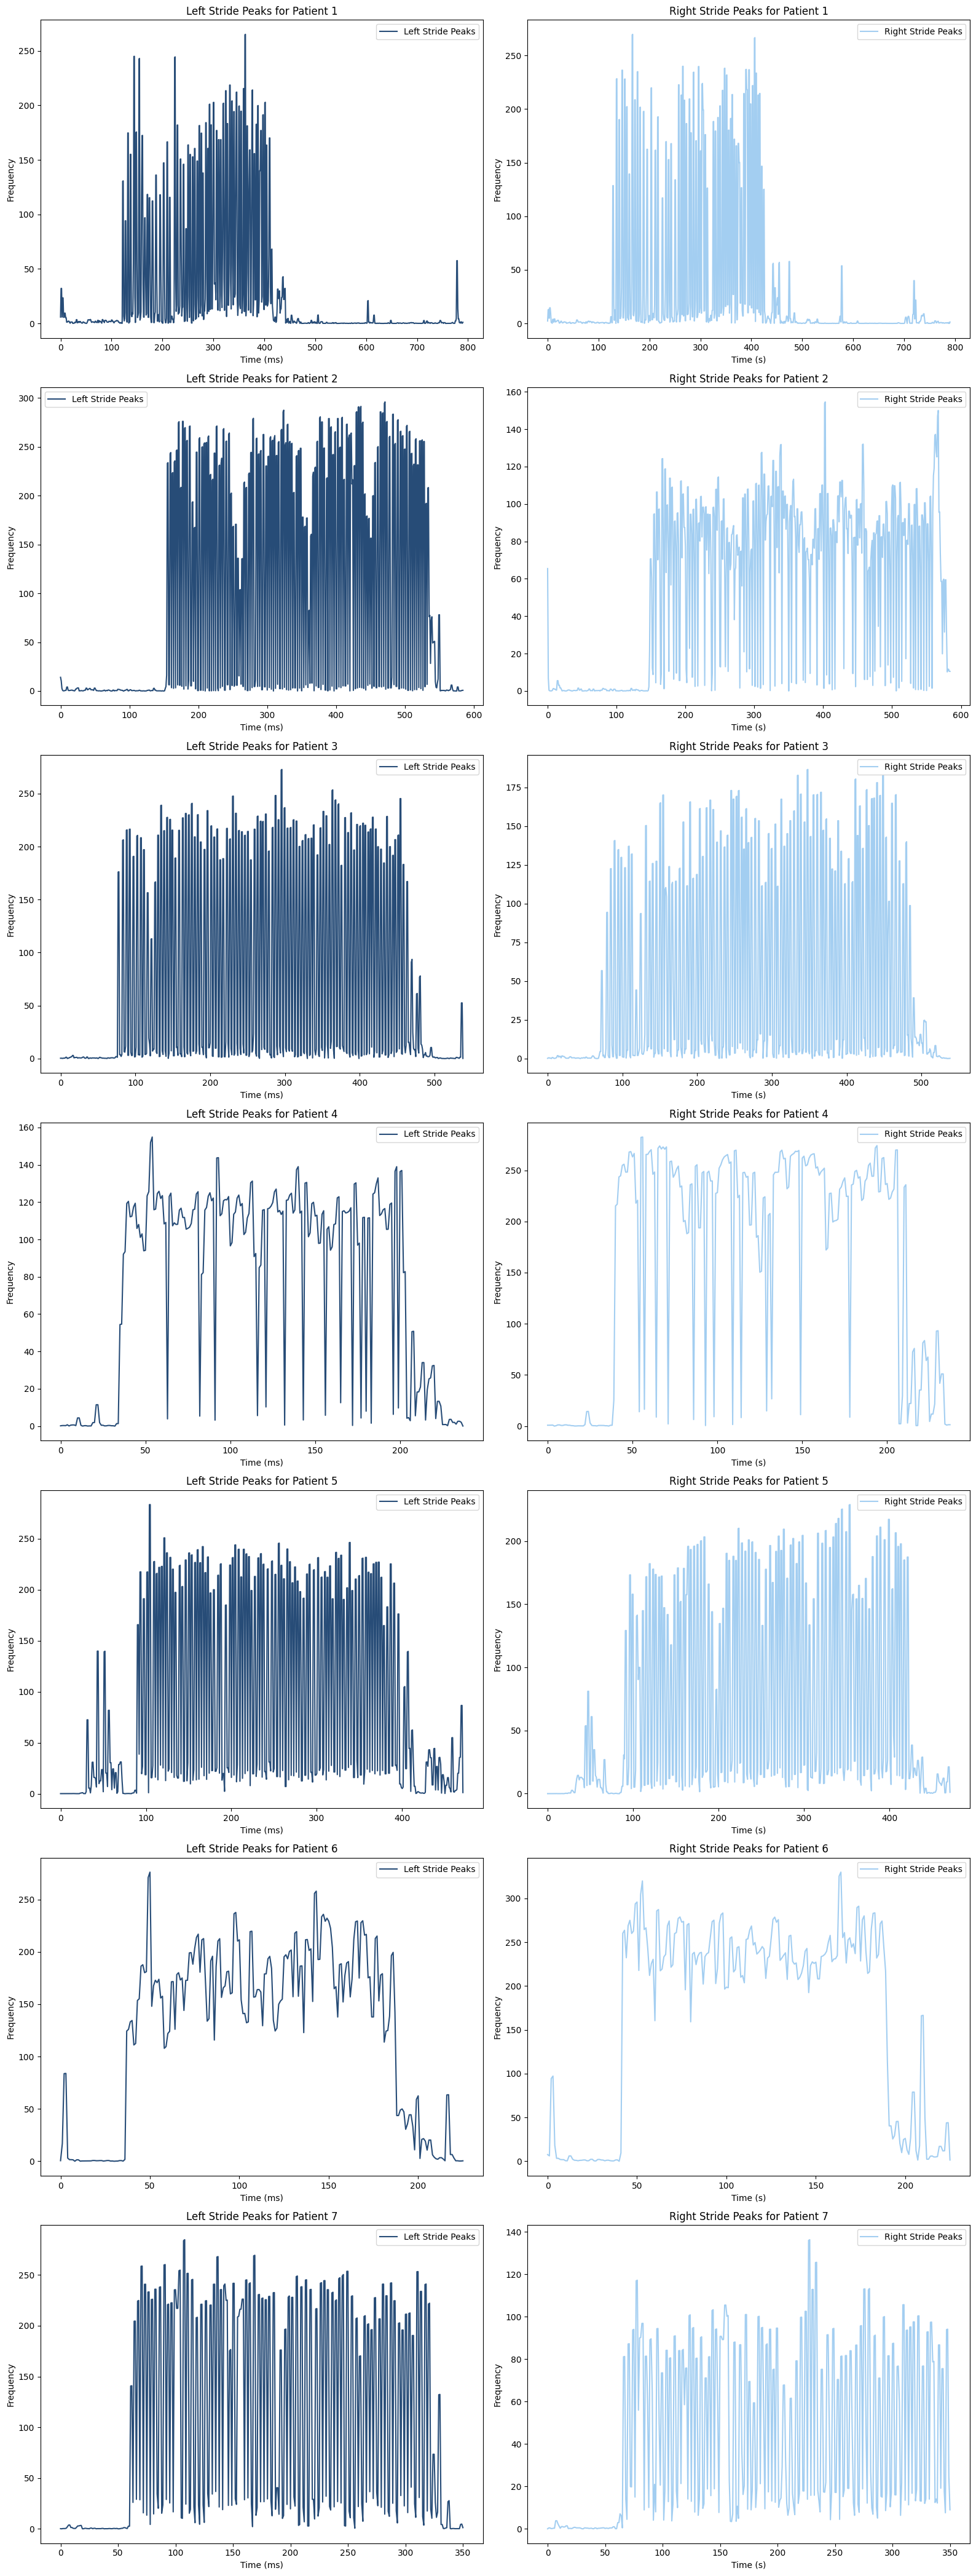

In [10]:
# Load the Gait Domain Features Metrics CSV files
cross_limbs_features_paths = [os.path.join(base_dir, patient_folder, 'cross_limb_metrics.csv') for patient_folder in os.listdir(base_dir)]
cross_limbs_features_paths = [path for path in cross_limbs_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(cross_limbs_features_paths)
n_cols = 2
n_rows = n_patients

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))

for idx, path in enumerate(cross_limbs_features_paths):
    data = pd.read_csv(path)
    ax = axes[idx]

    ax[0].plot(abs(data['left_peak']), color='#274c77', label='Left Stride Peaks')
    ax[0].set_title(f'Left Stride Peaks for Patient {idx + 1}')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    ax[1].plot(abs(data['right_peak']), color='#a3cef1', label='Right Stride Peaks')
    ax[1].set_title(f'Right Stride Peaks for Patient {idx + 1}')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

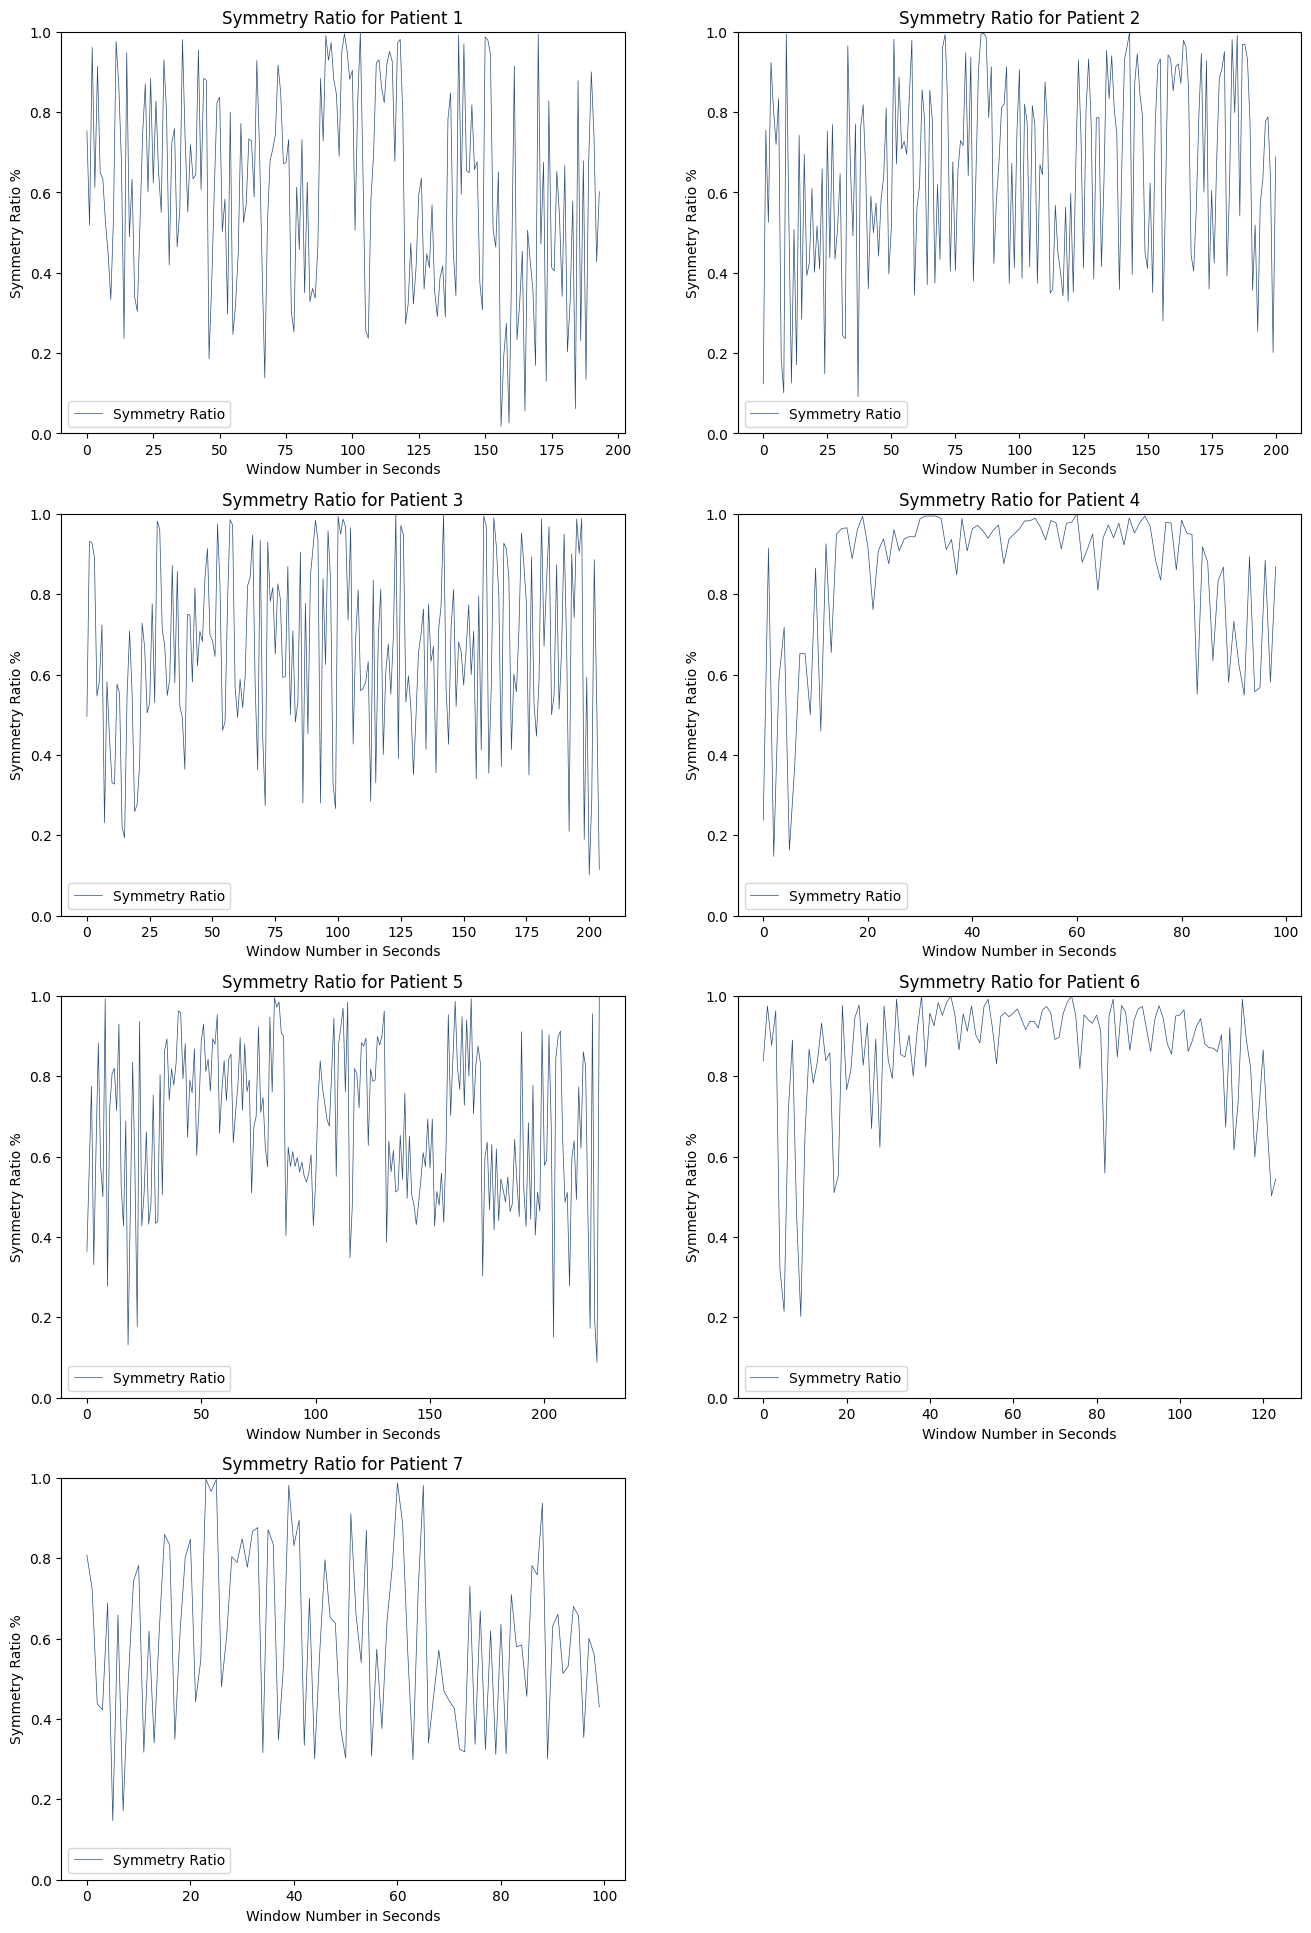

In [11]:
# Load the Gait Domain Features Metrics CSV files
gait_symmetry_features_paths = [os.path.join(base_dir, patient_folder, 'gait_features', 'summary_gait_metrics_gyroscope.csv') for patient_folder in os.listdir(base_dir)]
gait_symmetry_features_paths = [path for path in gait_symmetry_features_paths if path.__contains__('.DS_Store') == False]

# Calculate number of rows needed
n_patients = len(gait_symmetry_features_paths)
n_cols = 2
n_rows = math.ceil(n_patients / n_cols)

# Create the overall figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
axes = axes.flatten()

for idx, path in enumerate(gait_symmetry_features_paths):
    data = pd.read_csv(path)
    symmetry = data['symmetry_ratio']
    
    ax = axes[idx]

    ax.plot(symmetry, color='#274c77', linewidth=0.5, label='Symmetry Ratio')
    ax.legend()
    ax.set_title(f'Symmetry Ratio for Patient {idx + 1}')
    ax.set_xlabel('Window Number in Seconds')
    ax.set_ylabel('Symmetry Ratio %')
    ax.set_ylim(0, 1)
    

# Hide the empty subplot if the number is odd
if n_patients % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout

In [12]:
# Merge all features into a single CSV file
merged_df = aggregate_features(base_dir, label=1)
merged_df.to_csv(os.path.join(base_dir, 'stroke_features.csv'), index=False)

# Delete all the extra files
clean_extra_files(base_dir)
print("All extra files deleted.")

Deleted time_domain_metrics_gyroscope.csv in Data/Stroke/Patient_1
Deleted windowed_frequency_features_gyroscope.csv in Data/Stroke/Patient_1
Deleted cross_limb_metrics.csv in Data/Stroke/Patient_1
Deleted gyroscope.csv in Data/Stroke/Patient_1
Deleted gait_features/ in Data/Stroke/Patient_1
Deleted time_domain_metrics_gyroscope.csv in Data/Stroke/Patient_6
Deleted windowed_frequency_features_gyroscope.csv in Data/Stroke/Patient_6
Deleted cross_limb_metrics.csv in Data/Stroke/Patient_6
Deleted gyroscope.csv in Data/Stroke/Patient_6
Deleted gait_features/ in Data/Stroke/Patient_6
Deleted time_domain_metrics_gyroscope.csv in Data/Stroke/Patient_7
Deleted windowed_frequency_features_gyroscope.csv in Data/Stroke/Patient_7
Deleted cross_limb_metrics.csv in Data/Stroke/Patient_7
Deleted gyroscope.csv in Data/Stroke/Patient_7
Deleted gait_features/ in Data/Stroke/Patient_7
Deleted time_domain_metrics_gyroscope.csv in Data/Stroke/Patient_5
Deleted windowed_frequency_features_gyroscope.csv in D